In [26]:
#!pip install tensorflow-datasets
import os
from pathlib import Path
import cv2 #OpenCV for image processing-- read,write transform
import numpy as np# image handling
from tensorflow.keras.datasets import mnist# just the main bitch
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Pre-Processing




#Weird fucking issue
#Wanted mutiple numbers in a thing
#decided fuck you i cant give a shit 
#Load the number muncher
#THIS SECTION HAS REFERENCE CHATGBT 
#AS PER THE REQUIRMEENTS IN THE SYLLABUS I AM ACKNOLWEDGING ITS ASSISTANCE AND WILL LINK IN REPORT

#https://chatgpt.com/share/68ca428f-7efc-800b-9fa5-3e4a7afdec98


#issue numbr 2
#NOW THAT THERE IS MORE
#WE NEED TO MAKE SURE WE CAN SEGEMENT INTO PARTS LIKE
#EACH BLOCK IS 28 X 28

In [153]:
#Weird fucking issue
#Wanted mutiple numbers in a thing
#decided fuck you i cant give a shit 
#Load the number muncher
#THIS SECTION HAS REFERENCE CHATGBT 
#AS PER THE REQUIRMEENTS IN THE SYLLABUS I AM ACKNOLWEDGING ITS ASSISTANCE AND WILL LINK IN REPORT
BASE_DIR = Path(os.getcwd())

OUT_DIR  = BASE_DIR /"Preprocessed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

#https://chatgpt.com/share/68ca428f-7efc-800b-9fa5-3e4a7afdec98
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def mutiple_numbers(x,y,num_images, max_digits=10):
    imgs=[]
    labels=[]
    for i in range(num_images):
        digits_per_image = np.random.randint(1, max_digits + 1)
        #Random man selects in dices
        ints= np.random.randint(0, len(x), digits_per_image) 
        chosen_digits=[x[idx]for idx in ints]
        chosen_labels=[y[idx]for idx in ints]
        #Stack them like pringles
        img=np.hstack(chosen_digits)
        #There was a issue with cutting off parts to fix this issue The trees spoke to me

        imgs.append(img)
        labels.append(tuple(chosen_labels))#dont ask
        print(f"Generated {len(imgs)} images")

    return imgs,labels

# Generate 10 combined images
#imgs, labels = mutiple_numbers(x_train, y_train, num_images, max_digits=10)




#issue numbr 2
#NOW THAT THERE IS MORE
#WE NEED TO MAKE SURE WE CAN SEGEMENT INTO PARTS LIKE
#EACH BLOCK IS 28 X 28

Please choose how many images 2



Task 1 complete! Preprocessed images are in: C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Preprocessed


In [28]:
#To avoid unnessary code rewrite
df_train, df_test=tfds.load(
    'omniglot',
    split=['train','test'],
    as_supervised=True
)
imgs,labels=[],[]
for img,lab in tfds.as_numpy(df_train):
    imgs.append(img)
    labels.append(lab)
X=np.array(imgs)
y=np.array(labels)
#Dataset split
#https://stackoverflow.com/questions/47321709/how-to-split-train-and-test-dataset-to-x-train-y-train-and-x-test-y-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [183]:
BASE_DIR = Path(os.getcwd())

OUT_DIR  = BASE_DIR /"Preprocessed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

#preprocessing function area
def preprocess_single(img_bgr, out_size=128, pad=10):# expect 3channel BGR image- out size as 128x 128 pixel pad is just padding
    """
      Preprocess one image:
      1. Convert to grayscale
      2. Threshold to binary (digits white on black)
      3. Crop -> center pad -> resize to out_size (default 128x128)
      Returns: preprocessed image (uint8)
      """
    # --- Grayscale ---
    gray=cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)#convert 3 channel BGR to 1 channel grayscale IN DOCUMENTATION REPORT LOGIC IS MOST DIGIT REC MODESL DONT NEED COLOUR
#There was a issue with loading Mnist from keras, and using opencv  as it expected 8bit grayscale
#gray was a float not a uint8 so i had to convert it so opencv would accept it
    if gray.dtype != "uint8":
       gray=(gray* 255).astype("uint8")

    # --- Adaptive threshold (digits white on black) ---
    bw = cv2.adaptiveThreshold(gray, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,
                               25, 10)# works like this: Convert to gray-> use a adaptive threshold to handle any uneven lighting(The simple thres was a asshole to work with) the thresh binary part inverts images so digits become WHITE(THIS IS A COMMON PRACTISE IN MACHINE LEARNING LOOK AT PAPER E4)
    '''Remeber BW= Binary image ys=row indices of white pixels and xs= column indices of white pixels'''

    # --- Tight crop around digits ---
    ys, xs = np.where(bw > 0)
    if xs.size and ys.size:
        x0,x1=xs.min(),xs.max()#left edge of digit, right edge of digit
        y0,y1=ys.min(),ys.max()#top edge of digit, bottom edge of digit
        tight=bw[y0:y1+1,x0:x1+1]#Removes all unnessary black background and focuses only on the digit by cropping the image to the defined rectangle
    else:
        tight=bw #Troubleshooter ensures array always returns even if none found

    # --- Center pad to square ---
    digit_height,digit_width=tight.shape
    canvas_side = max(digit_height, digit_width) + 2 * pad
    padded_canvas = np.zeros((canvas_side, canvas_side), dtype=np.uint8)#make the empty
    # offset calculations to center on the canvas
    yoffset=(canvas_side-digit_height)//2
    xoffset=(canvas_side -digit_width)//2
    padded_canvas[yoffset:yoffset+digit_height,xoffset:xoffset+digit_width]=tight
    # --- Resize to fixed size (default 128x128) ---
    resized = cv2.resize(padded_canvas, (out_size, out_size), interpolation=cv2.INTER_AREA)# resize to 128x128 and the inter-area acts like scale feature in css,
    return resized
#ML models need consistent image sizing that is why it is resized that is important mention report in basic part.

dataset_testing=int(input("Please select a dataset[0,1,2]1=Create new images"))
if dataset_testing ==  0:
  #Load mnist  images and labels into training data
  #This will allow near 60k trainign images and around 10k test images, without having to use the kraggle repository and enaring with crosiant
  (x_train,y_train),(x_test,y_test)=mnist.load_data()
  print("Training Images: ", x_train.shape)#x train is image of a digit
  print("Training Labels: ",y_train.shape) # y_train is the label of the digit aka 0-9
  x_train = x_train.astype('float32') / 255.0
  x_test = x_test.astype('float32') / 255.0
  #ADDED ONE HOT ENCODING--------vital for bin
  y_train_cat=to_categorical(y_train, num_classes=10)
  y_test_cat =to_categorical(y_test, num_classes=10)
    
# ---------- Run preprocessing and save----------
  which_nums_processing=100#SET TO 100 because its small  this is a test mech
  for i in range(which_nums_processing):
    #img_gray = x_train[i]#must be SQUARE LINES NOT THE BRACKETS OR ELSE IT WILL SAY OBECJT NOT CALLABLE!!!!!
  #  img_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR) #convert to BGR so its compatible with the preprocesser function
    #send to preprocess
      img = x_train[i]
      if len(img.shape) == 2:  # grayscale
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      elif len(img.shape) == 3 and img.shape[2] == 3:  # already BGR/RGB
        img_bgr = img.copy()
      else:
        raise ValueError(f"Unexpected image shape: {img.shape}")
  pre_img = preprocess_single(img_bgr, out_size=128)   # <--- made images bigger
  # Save output PNG
  out_png = OUT_DIR / f"img_{i}_preprocessed.png"
  cv2.imwrite(out_png, pre_img)
  print(f"[OK] Image {i}: saved {out_png}")

if dataset_testing == 1:
    num_images=int(input("Please choose how many images"))
    mutiple_numbers(x_train, y_train, num_images, max_digits=10)
     # Visualize only 4
    for i, img in enumerate(imgs):
        pre_img = img.astype(np.uint8)
        out_png = OUT_DIR / f"img_{i}_preprocessed.png"
        cv2.imwrite(str(out_png), pre_img)
    print(f"\nTask 1 complete! Preprocessed images are in: {OUT_DIR}")
    


elif dataset_testing == 2:
    #To avoid unnessary code rewrite
  df_train, df_test=tfds.load(
      'omniglot',
      split=['train','test'],
      as_supervised=True
  )
  x_train,y_train=[],[]
  for img, lab in tfds.as_numpy(df_train):
    x_train.append(img)
    y_train.append(lab)
  x_train,y_train=np.array(x_train),np.array(y_train)

  #append img and labels to test instances
  x_test,y_test=[],[]

  for img,lab in tfds.as_numpy(df_test):
      x_test.append(img)
      y_test.append(lab)
x_test,y_test=np.array(x_test),np.array(y_test)
  #Dataset split
  #https://stackoverflow.com/questions/47321709/how-to-split-train-and-test-dataset-to-x-train-y-train-and-x-test-y-test

#this is incomplete
def preprocess_letters(img, out=28):
  #resize
  img_resized=cv2.resize(img,(out,out))
  #grayscale convert
  if len(img_resized.shape)==3 and img_resized.shape[-1]==3:
    img_resized=cv2.cvtColor(img_resized,cv2.COLOR_RGB2GRAY)
  #normalize 0-1
  img_resized=img_resized.astype("float32")/255.0
  return img_resized
x_train = np.array([preprocess_letters(img) for img in x_train])
x_test  = np.array([preprocess_letters(img) for img in x_test])



#Loop over extensions, Build path, check file exists, return if path found else return none

def find_image(idx):
    """Return path for numbered file with common extensions."""
    for ext in (".jpg", ".jpeg", ".png", ".webp"):
        p = os.path.join(BASE_DIR, f"{idx}{ext}")
      ##      return p
    return None


print(f"\nTask 1 complete! Preprocessed images are in: {OUT_DIR}")




Please select a dataset[0,1,2]1=Create new images 1
Please choose how many images 33



Task 1 complete! Preprocessed images are in: C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Preprocessed

Task 1 complete! Preprocessed images are in: C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Preprocessed


In [ ]:
#CLEAN AND PREPROCESS THE DATA


#Segmentation


In [32]:

BASE_DIR = Path(os.getcwd())
IN_DIR  = BASE_DIR /"Preprocessed"
OUT_DIR  = BASE_DIR /"segmentation"

IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
#Contour segmentation
def segment_contours(bw, dilate_kernel=(3,3), min_area=30):
    dil = cv2.dilate(bw, cv2.getStructuringElement(cv2.MORPH_RECT, dilate_kernel), 1)
    contours, _ = cv2.findContours(dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if w*h >= min_area and h > 6 and w > 3:
            boxes.append((x,y,w,h))
    return sorted(boxes, key=lambda b: b[0])

# --- Splitter for wide blobs ---
def projection_split(sub_bw, min_run=6):
    v = (sub_bw.sum(axis=0) > 0).astype(np.uint8)
    runs, start = [], None
    for i, val in enumerate(v):
        if val and start is None:
            start = i
        if not val and start is not None:
            if i - start >= min_run:
                runs.append((start, i))
            start = None
    if start is not None and len(v)-start >= min_run:
        runs.append((start, len(v)))
    return runs

# --- Main segmentation ---
def segment_digits(img_gray):
    _, bw = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    boxes = segment_contours(bw)

    refined = []
    for (x,y,w,h) in boxes:
        if w > 1.5 * h:  # only split if clearly wide
            sub = bw[y:y+h, x:x+w]
            splits = projection_split(sub, min_run=6)
            if len(splits) >= 2:
                for sx, ex in splits:
                    refined.append((x+sx, y, ex-sx, h))
                continue
        refined.append((x,y,w,h))

    refined = sorted(refined, key=lambda b: b[0])

    vis = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    for (x,y,w,h) in refined:
        cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 1)  # <!-- thinner box

    return refined, vis

# --- Run on all Task 1 images ---
for fname in os.listdir(IN_DIR):
    if not fname.lower().endswith(".png"):
        continue
    path = os.path.join(IN_DIR, fname)
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    boxes, vis = segment_digits(img_gray)
    base = os.path.splitext(fname)[0]

    out_path = os.path.join(OUT_DIR, f"{base}_boxes.png")
    cv2.imwrite(out_path, vis)

    print(f"[OK] {fname}: {len(boxes)} digits detected → {out_path}")

print("\nTask 2 complete. Overlays with thin boxes saved in:", OUT_DIR)



[OK] image1_preprocessed.png: 4 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\image1_preprocessed_boxes.png
[OK] image2_preprocessed.png: 3 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\image2_preprocessed_boxes.png
[OK] image3_preprocessed.png: 2 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\image3_preprocessed_boxes.png
[OK] image4_preprocessed.png: 3 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\image4_preprocessed_boxes.png
[OK] image5_preprocessed.png: 4 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\image5_preprocessed_boxes.png
[OK] image6_preprocessed.png: 5 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\image6_preprocessed_boxes.png
[OK] img_0_preprocessed.png: 0 digits detected → C:\Users\yugaa\Documents\Intelligentsystems\notebooks\segmentation\im

# Detection Test Printing Random Number 

(60000, 28, 28) (60000,)
1


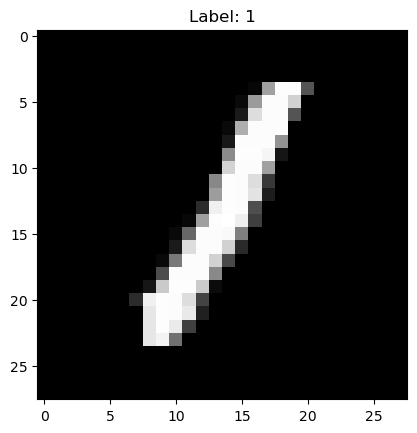

In [19]:
#test The printing
BASE_DIR = Path(os.getcwd())
IN_DIR  = BASE_DIR /"Segmentation"
OUT_DIR  = BASE_DIR /"Detected"

IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)


#Output the image and label to screen
import matplotlib.pyplot as plt

import random
random_i=random.randint(0,999)

print(x_train.shape, y_train.shape)  # print shape
plt.imshow(x_train[random_i], cmap='gray')  # See the first digit
plt.title(f"Label: {y_train[random_i]}")
print(f"{y_train[random_i]}")
plt.show()
#This part above might be good for gui


# Digit Detection


In [36]:
#Mutiple layer perception
#connected neural net
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
def Multiple_Layer_Perceptron(input_shape):
    name="Multiple_Layer_Perceptron"
      #The yes/no decision layer stack
    model=Sequential(name=name)
    
    model.add(Flatten(input_shape=input_shape))#turn into 1 flat layer aka 28 x 28 in line of 784 pix instead of grid
    model.add(Dense(128,activation='relu'))#rectafy liner unit keep pos kill neg------this si the first hidden layer
    model.add(Dense(64,activation='relu'))#second hidden layer
    model.add(Dense(10,activation='softmax'))#Output layer, 10 neurons--all outputs must + to get 1
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    #model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=['accuracy'])
    #model.fit(x_train,y_train)
    #hamTest=eval_model(model,x_test,y_test,"MLP")
    return model
    
Multiple_Layer_Perceptron((28,28))

#Reinforcement and supervision learning test
    

Model: "Multiple_Layer_Perceptron"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=Multiple_Layer_Perceptron, built=True>

In [449]:
#cnn
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
def Convolutional_Neural_Network(input_shape):
    name="Convolutional_Neural_Network"
    model=keras.Sequential([ 
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu')
    ],name=name)
  
    model.summary()
Convolutional_Neural_Network((28,28))

Model: "Convolutional_Neural_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#

In [1]:
#This is the evalute model tester function
def eval_model(model,x_test,y_test,model_name="hambubgerV1"):
  loss,accuracy=model.evaluate(x_test,y_test)
  print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
  return accuracy


In [27]:
# Choose Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Reshape

def Recurrent_Neural_Networks(input_shape):
    model = Sequential([
        Input(shape=input_shape),        # Proper way to define input shape
        Reshape((28, 28)),              # reshape 28x28 image → sequence
        LSTM(128),                      # LSTM layer
        Dense(32, activation="relu"), # Output layer for 10 digits
        Dense(10, activation="softmax") # Output layer for 10 digits
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
   
    model.summary()
    return model
Recurrent_Neural_Networks((28,28))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,842 (331.41 KB)

 Trainable params: 84,842 (331.41 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_1, built=True>

Please select a model(0=default program, 1=MLP,2= CNN, 3=DNN, 4=RNN) 4


You have selected: Recurrent Neural Networks (RNNs)


Please select a option(1=Test Model, 2=Train Model) 1
Please choose index betwen 0-900:  46


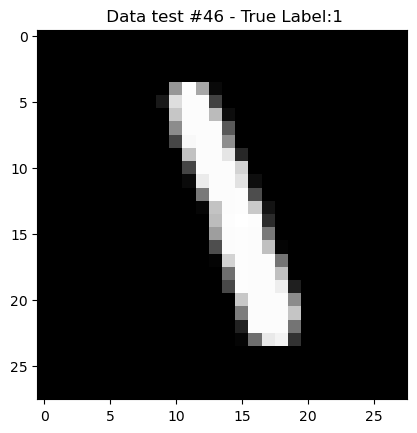

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,842 (331.41 KB)

 Trainable params: 84,842 (331.41 KB)

 Non-trainable params: 0 (0.00 B)

469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.1594 - loss: 2.2272
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Model predicts 1
True label is: 1
IT IS CORRECT
saved image to C:\Users\yugaa\Documents\Intelligentsystems\notebooks\Detected\label_46_predicted_1.png


In [60]:
BASE_DIR = Path(os.getcwd())
IN_DIR  = BASE_DIR /"Segmentation"
OUT_DIR  = BASE_DIR /"Detected"

IN_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
#Fully connected neural net
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import backend as K
#The below is a calling method to test all of the types of models
#THIS DOES NOT INCLUDE TRAINING!!!! THIS IS TO TEST SPECFIC ONES



available_models=["Pray","Multi Layer Perception Model (MLPs)","Convolutional Neural Networks (CNNs) ","Deep Neural Networks (DNNs) ","Recurrent Neural Networks (RNNs)"]
which_model=int(input("Please select a model(0=default program, 1=MLP,2= CNN, 3=DNN, 4=RNN)"))
print(f"You have selected: {available_models[which_model]}")
train_or_test=int(input("Please select a option(1=Test Model, 2=Train Model)"))
if train_or_test==1:
    dataset='test'
    reinforce=False
elif train_or_test==2:
    dataset='train'
    reinforce=True
else:
    print("I dont want to add another option")
K.clear_session()
match which_model:
  #Multi Layer Perception Model (MLPs)
  case 1:
  #specific test
    i=int(input("Please choose index betwen 0-900: "))
    if i >= 0 and i <=900:
      img=x_test[i]
      true_label=y_test[i]
      #SHOW ME THE MONEY
      plt.imshow(img,cmap='gray')
      plt.title(f" Data test #{i} - True Label:{true_label}")
      plt.show()
      model = Multiple_Layer_Perceptron(x_train.shape[1:])
      model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=['accuracy'])
      img_mlp = np.expand_dims(img, axis=0)
      predicted_label=np.argmax(model.predict(img_mlp))

   
         #Somehow lost a variable at some point so were doing longer math
    if len(np.shape(true_label))>0:#Prob a one hot girlie
        truth_of_label_index=int(np.argmax(true_label))
    else:
        truth_of_label_index=int(true_label)
    print(f"Model predicts {predicted_label}")
        #Had to Change back
    print(f"True label is: {truth_of_label_index}")
      
    if predicted_label != truth_of_label_index:
        reinforcement(i=i, model=model,model_index=1, dataset=dataset, reinforce=reinforce)
    else:
        print("IT IS CORRECT")
  #Convolutional Neural Networks (CNNs) 
  case 2:
    print(f"{available_models[which_model]}")
  #
  case 3:
    print(f"{available_models[which_model]}")
  #Recurrent Neural Networks (RNNs)
    #https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
#This cheatsheet is the only way to understand what on earth the math is
  case 4:
    dataset=dataset
    i=int(input("Please choose index betwen 0-900: "))
    if i >= 0 and i <=900:
          img=x_test[i]
          true_label=y_test[i]
          #SHOW ME THE MONEY
          plt.imshow(img,cmap='gray')
          plt.title(f" Data test #{i} - True Label:{true_label}")
          plt.show()
        #Build the rnn model
        #MUST MAKE SURE THE THING IS PASSED AS TWO AGURMENTS INSTEAD OF ONE TUPLE . IE (28,28) IS WRONG but ((28,28)) is correct
          model=Recurrent_Neural_Networks(x_train.shape[1:])#test mechs are x_train.shape[1:] or 28,28
          #train the model
          y_train_cat = to_categorical(y_train, num_classes=10)
          model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
          model.fit(x_train,y_train_cat,epochs=1,batch_size=128,verbose=1)
        #predict
       
          img_rnn = np.expand_dims(img, axis=0)
          predicted_label=np.argmax(model.predict(img_rnn))
         
          if len(np.shape(true_label)) > 0:  # one-hot
            truth_of_label_index = int(np.argmax(true_label))
          else:
            truth_of_label_index = int(true_label)
              
          y_input = to_categorical([truth_of_label_index], num_classes=10)  # shape (1, 10)
          print(f"Model predicts {predicted_label}")
          print(f"True label is: {truth_of_label_index}")
        
          if predicted_label != truth_of_label_index:
                reinforcement(i=i, model=model,model_index=4, dataset=dataset, reinforce=reinforce)
          else:
              print("IT IS CORRECT")
        
          
  case _:
    print('You selected default or an invalid option.')

img_uint8 = (img * 255).astype(np.uint8)
filename = OUT_DIR/ f"label_{i}_predicted_{truth_of_label_index}.png"
cv2.imwrite(str(filename), img_uint8)

print(f"saved image to {filename}")
#When testying try 54 its weird


In [14]:
#reinforcement model
#model = multiple_layer_perceptron_model(x_train.shape[1:])  

#For unknown reasons this code has decieded to be a asshole, please do not question why it will take vengeage
#Reinforcement Testing function is mostly for weird cases i dont really know when we would want it
from tensorflow.keras.utils import to_categorical
import numpy as np

def reinforcement(i, model, model_index, dataset, reinforce=True):
    print(f"Model index: {model_index}")

    # Select the correct image and true label
    if dataset == 'test':
        img = x_test[i]
        true_label = y_test[i]
    else:
        img = x_train[i]
        true_label = y_train[i]

    # Expand dims for model input
    img_input = np.expand_dims(img, axis=0)  # shape: (1, 28, 28) or (1, 28, 28, 1)

    # Convert true_label to scalar if one-hot
    if isinstance(true_label, np.ndarray) and len(true_label.shape) > 0:
        truth_of_label_index = int(np.argmax(true_label))
    else:
        truth_of_label_index = int(true_label)

    # Predict label
    predicted_label = int(np.argmax(model.predict(img_input)))

    print(f"Predicted label: {predicted_label}")
    print(f"True label: {truth_of_label_index}")

    # Reinforce only if prediction is wrong
    if predicted_label != truth_of_label_index and reinforce:
        print("Incorrect! Updating model with correct label...")

        # Determine whether to use sparse or categorical
        if model.loss == 'categorical_crossentropy':
            y_input = to_categorical([truth_of_label_index], num_classes=10)
        else:  # sparse_categorical_crossentropy
            y_input = np.array([truth_of_label_index])

        # Update model
        model.fit(img_input, y_input, epochs=1, verbose=0)
        print("Model updated!")


In [ ]:
#This is for other detection


# Letter detection


In [ ]:
i=
def predict_letters(i,model,dataset='test',save_image=True):
  """
  predict oimage label, show it and print predict
  para
    index
    model-being used
    dataset-train or test data
    save_image: if true save image to outdir
  """
  if dataset=='test':
    img=x_test[i]
    true_label=y_test[i]
  else:
    img= x_train[i]
    true_label=y_train[i]
  #PREPARE FOR MODEL

img_input=np.expand_dims(img,axis=0)
predict_label=np.argmax(model.predict(img_input))
#display
plt.imshow(img.squeeze(),cmap='gray')
plt.title(f"Image #{i} - True: {true_label}, Predicted Value: {predict_label}")
plt.axis=("off")
plt.show()
print(f"Predicted: {predict_label}")
print(f"True: {true_label}")
